【実験の背景と目的】
人工知能分野(AI)の技術発展のスピードは目を見張るものがあり, 我々の日常生活においても急速にその利用が広がっている. 
AI分野のプログラム開発では, それに特化したライブラリを用いることが一般的となっている. この実験では, PythonのためのライブラリであるPytorchを利用し, 実際にAIを動かしながらその使い方, 改良, 評価の方法などについて学習する.  
【第1週 分類問題】
第1週目は分類問題を取り上げる. 分類問題とは, 与えられたデータ(例えば動物の画像データ)がどのようなクラスに分類されるか(犬か猫か)といった判定を行う問題である.   
このプログラムはFashin-MNISTというデータに対し, PyTorchを利用し, 機械学習によって画像認識・分類を行うプログラムである.  
【実験方法】
まずはプログラム全体を動かし, このプログラムが動作することを確認しよう.  
続いて, 各コードを見ながら, (大まかに)プログラム全体でどのような処理が行われているかを理解しよう.   
最後に, 予測精度を向上させるためにはどのようなことが必要かを調査し, 分類の精度向上に挑戦しよう. 

> %matplotlib inline

後の行でグラフの作成用にmatplotlib.pyplotを読み込んでいる.  
この設定を実施することで, ターミナルの出力が出力されるようになる.  
plt.show()が不要になるのが便利. 

In [1]:
%matplotlib inline

ここでは各種ライブラリを読み込む. 

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

次に, torchvisionのdatasetsから, MNISTというデータを読み込む.  
MNIST: 
10種類のアラビア数字に対応した画像データが含まれるデータセットである.
6万枚の訓練用データと1万枚のテスト用データが用意されている.  
ラベルの内容は下記の通りである.  

- ラベル「0」： 数字の0
- ラベル「1」： 数字の1
- ラベル「2」： 数字の2
- ラベル「3」： 数字の3
- ラベル「4」： 数字の4
- ラベル「5」： 数字の5
- ラベル「6」： 数字の6
- ラベル「7」： 数字の7
- ラベル「8」： 数字の8
- ラベル「9」： 数字の9

データの中身は8bitグレースケール(0~255の値に対応), 28*28ピクセルの画像データである. すなわち, 0〜255の数値が784個で1セットとなり, 画像データを作っており, この画像データが数万枚用意されているということである. 

機械学習を行うためには, ネットワークのパラメータを最適化するための訓練データと, 訓練がうまくいっているか確認するためのテストデータが必要である. ここではダウンロードしたFashinMnistデータを用いて, 訓練用のデータ(training_data)とテスト用のデータ(test_data)のインスタンスを作成している.

ToTensor()を使うことで, 画像データをテンソルに形式に変換し, また, 値を0〜1の範囲にスケーリングしている. これにより, ニューラルネットワークの入力として適した形状に変換している.

In [3]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:13<00:00, 762kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 165kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 685kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


訓練用データとテスト用データに対し, それぞれデータローダーを作成する.  
バッチサイズは一度に処理するデータの数を表す. 今回は32. 慣例的に2^nを用いることが多い.    
  
DataLoader: PyTorchのtorch.utils.dataモジュールに含まれるクラスで、データセットを効率的にバッチ処理するために用いられる. 
Xは入力データ(今回は画像), yはラベル(クラス, 今回は整数)を表している. Nはバッチサイズ、Cはチャンネル数（グレースケール画像の場合は1）、Hは高さ、Wは幅である. 

今回のようにデータを訓練データとテストデータを分割して検証を行う方法をホールドアウト法と呼ぶ. テストデータの割合は20%程度が一般的である. 他にもデータ全体をいくつかの集団に分割し, 各集団をテストデータとして複数回検証を行う公差検証法（k-fold）などが存在する.
https://datawokagaku.com/kfoldcv/

In [4]:
batch_size = 32

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64


CUDA: GPUをグラフィック以外の計算処理で用いるためのライブラリ. cudaが使える場合はcudaを用いてGPUで計算. 使えない場合はcpuで計算を行う.

model定義:
入力される画像が28x28ピクセルの画像, 分類ラベルが10種類の衣類であるため, 中間層を挟んで28x28x512から512x10のデータに変換するネットワークを定義している. Linear()は線形変換である. 変換のパラメータ(つまり係数)を学習を通じ最適化していくことになる.    
参考: https://cvml-expertguide.net/terms/dl/layers/fully-connected-layer/    
参考: https://qiita.com/age884/items/0d9cff09f131285b08c0

ReLU:
ニューラルネットワークで用いられる「活性化関数」の1つである. 入力値が0以下の場合は0を出力, 入力値が0より大きい場合は入力値と同じ値を出力する関数. (ランプ関数と同じ)階層が深いディープニューラルネットワークにおいて生じる「勾配消失問題」を解消できるという特徴がある. また計算式が単純という特徴, 入力値が0以下の場合は出力が0であることから生体ニューロンのような発火しないニューロンに対応する状態の表現が可能という特徴もあり, 頻繁に用いられる活性化関数である.   
参考: https://atmarkit.itmedia.co.jp/ait/articles/2003/11/news016.html

In [5]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


次のコードではPyTorchのライブラリを用いて損失関数と最適化アルゴリズムを定義している.   

CrossEntropyLoss は、主に多クラス分類タスクで使用される損失関数である. 入力（モデルの出力であるロジット）に対してソフトマックス関数を適用して確率分布に変換し, その確率分布と真のラベル（one-hotエンコーディングされていなくても良い）との間のクロスエントロピーを計算する. この損失関数はモデルの予測が真のラベルからどれだけ離れているかを数値化する指標となるため, 損失関数の値が最小となるように最適化が行われる. 

torch.optim.SGD は確率的勾配降下法 (Stochastic Gradient Descent, SGD) を最適化アルゴリズムとして選択し、そのインスタンスを作成するコードである. 

lr=1e-3: learning rate(学習率)を設定している. 学習率はパラメータの更新を行う際のステップの大きさを制御するハイパーパラメータの一つである.    

scheduler: StepLRというスケジューラを使用し, 学習率を調整している. トレーニングが進むと一定のエポックごとに学習率を減少させ, モデルが収束するのを補助している. 

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)


In [7]:
# 学習過程の記録用リスト
train_losses = []
val_losses = []

訓練用の関数を定義する.   
バッチごとに先ほど定義した損失関数と最適化手法で最適化を実行する. 

In [8]:
def train(dataloader, model, loss_fn, optimizer, train_losses):
    model.train()
    size = len(dataloader.dataset)
    fold_train_losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        fold_train_losses.append(loss.item())

        # batchが100ごとにlossを出力
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    # エポックごとの平均損失を記録
    train_losses.append(np.mean(fold_train_losses))


テスト用の関数を定義する. 

In [9]:
def test(dataloader, model, loss_fn, val_losses):
    model.eval()
    size = len(dataloader.dataset)
    fold_val_losses = []
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            fold_val_losses.append(loss.item())
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # エポックごとの平均損失と正解率を計算
    avg_loss = np.mean(fold_val_losses)
    accuracy = correct / size
    val_losses.append(avg_loss)
    
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

epochs=(エポック数): 訓練データを学習させる際の繰り返し数. 今回はepochs=5とすることで, 5回学習を繰り返している. 1回の学習の中でtrain関数とtest関数を呼び出している.    
また, バッチサイズが64であるため, 1エポックの中では6万個の訓練用データから64個のデータを用いて学習を繰り返している. 

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_losses)
    test(test_dataloader, model, loss_fn, val_losses)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.302675  [    0/60000]
loss: 2.304223  [ 3200/60000]
loss: 2.301329  [ 6400/60000]
loss: 2.297786  [ 9600/60000]
loss: 2.293133  [12800/60000]
loss: 2.300654  [16000/60000]
loss: 2.281574  [19200/60000]
loss: 2.287068  [22400/60000]
loss: 2.279359  [25600/60000]
loss: 2.251985  [28800/60000]
loss: 2.274730  [32000/60000]
loss: 2.276903  [35200/60000]
loss: 2.245931  [38400/60000]
loss: 2.269161  [41600/60000]
loss: 2.265766  [44800/60000]
loss: 2.230007  [48000/60000]
loss: 2.248315  [51200/60000]
loss: 2.232397  [54400/60000]
loss: 2.239661  [57600/60000]
Test Error: 
 Accuracy: 45.3%, Avg loss: 2.238800 

Epoch 2
-------------------------------
loss: 2.245890  [    0/60000]
loss: 2.257106  [ 3200/60000]
loss: 2.223396  [ 6400/60000]
loss: 2.252151  [ 9600/60000]
loss: 2.235405  [12800/60000]
loss: 2.261781  [16000/60000]
loss: 2.197090  [19200/60000]
loss: 2.216788  [22400/60000]
loss: 2.198744  [25600/60000]
loss: 2.127771  [28800/60000

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

モデルの評価を行う. テストデータの正解と, モデルの予測値を比較する. 

In [13]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "4", Actual: "7"


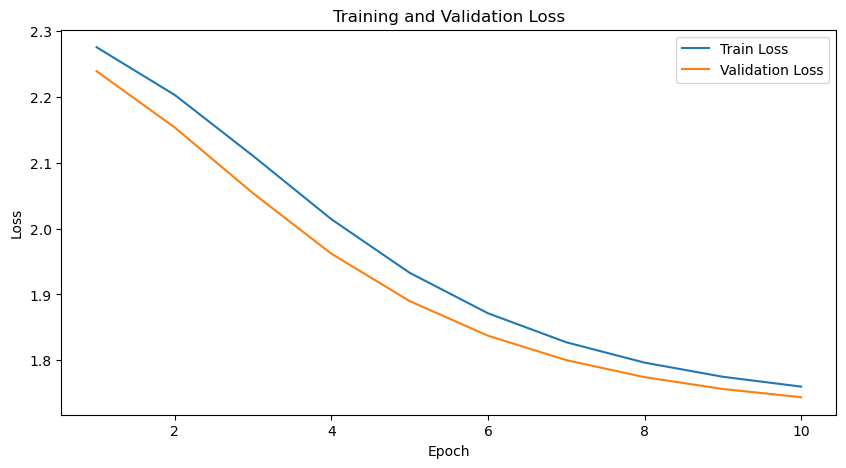

In [14]:
# 学習過程の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

混同行列を生成する. 混同行列はモデルの正答率の傾向を把握するのに便利である. 
もし, 訓練したモデルの正答率が100%であれば, 混同行列は単位行列となる. 

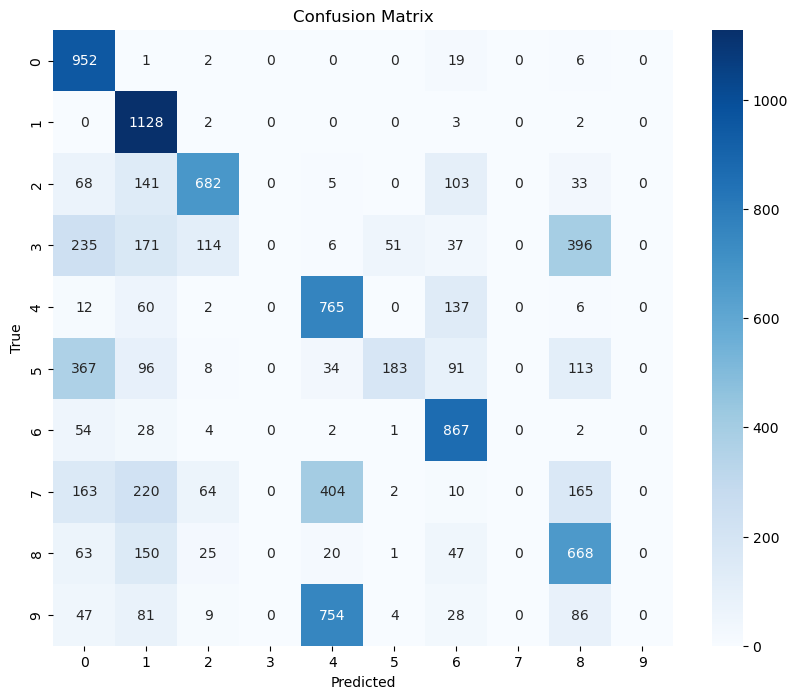

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# テストデータに対する予測を取得
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        all_preds.extend(pred.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 混同行列を計算
cm = confusion_matrix(all_labels, all_preds)

# 混同行列を表示
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


参考にした資料等:  
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
https://zenn.dev/morixx/articles/d3268e4ce17e03  
https://qiita.com/satochin/items/557cdf0bcedaad108ba5  
https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c   
https://zenn.dev/opamp/articles/ddcfd32bcd1315
